# Project 4 - WEST NILE VIRUS

The first markdown cell in a notebook is a great place to provide an overview of your entire project. You will likely want to at least state your

## Problem Statement

## Executive Summary

If you want to, it's great to use relative links to direct your audience to various sections of a notebook. **HERE'S A DEMONSTRATION WITH THE CURRENT SECTION HEADERS**:

### Contents:
- [2017 Data Import & Cleaning](#Data-Import-and-Cleaning)
- [2018 Data Import and Cleaning](#2018-Data-Import-and-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Visualization](#Visualize-the-data)
- [Descriptive and Inferential Statistics](#Descriptive-and-Inferential-Statistics)
- [Outside Research](#Outside-Research)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

**If you combine your problem statement, executive summary, data dictionary, and conclusions/recommendations, you have an amazing README.md file that quickly aligns your audience to the contents of your project.** Don't forget to cite your data sources!

*All libraries used should be added here*

In [1]:
#import libraries
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## Data Import and Cleaning

In [2]:
#import data
train = pd.read_csv('../project-4-west-nile-virus_work/predict-west-nile-virus/train.csv')
test = pd.read_csv('../project-4-west-nile-virus_work/predict-west-nile-virus/test.csv')
weather = pd.read_csv('../project-4-west-nile-virus_work/predict-west-nile-virus/weather.csv')
spray = pd.read_csv('../project-4-west-nile-virus_work/predict-west-nile-virus/spray.csv')

In [3]:
# convert to date format
weather['Date'] = pd.to_datetime(weather.Date, format='%Y-%m-%d')
# fill missing values in Station 2 with value from Station 1
# fill missing values in Station 2 with value from Station 
cols = ['Tavg', 'Depart', 'WetBulb', 'Heat', 'Cool', 'Depth',
        'SeaLevel', 'AvgSpeed']
for col in cols:
    if weather[col].dtypes == 'object':
        for k, v in enumerate(weather[col]):
            if v == 'M' and weather.iloc[k]['Station'] == 1:
                weather.loc[k,col] = weather[col][k+1]
            if v == 'M' and weather.iloc[k]['Station'] == 2:
                weather.loc[k,col] = weather[col][k-1]
        weather[col] = pd.to_numeric(weather[col])
        
weather = weather.drop(["Sunrise", "Sunset", "CodeSum","Water1","SnowFall","PrecipTotal","StnPressure"], axis=1)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null object
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 985.0+ KB


In [5]:
#del variables that are not useful
#address related are deleted as location is determined by Latitude and Longuitude
#checked online all species are relevant for WNV
def del_var(data):
    try:
        del data['Address']
        del data['Block']
        del data['Street']
        del data['AddressNumberAndStreet']
        del data['AddressAccuracy']
        del data['Species']
    except:
        pass

In [6]:
del_var(train)

In [7]:
del_var(test)

In [8]:
def aggregate_train (data):
    grouped = data.groupby(['Date', 'Trap', 'Latitude', 'Longitude'])
    aggregated = pd.DataFrame(grouped.agg({'NumMosquitos': np.sum, 'WnvPresent': np.max})).reset_index()
    aggregated.sort_values(by='NumMosquitos', ascending = False)
    aggregated.sort_values(by='Date', inplace=True)
    aggregated = aggregated.reset_index(drop = True)
  #  aggregated['Month'] = aggregated.Date.month
  #  aggregated['Year'] = aggregated.Date.year
    return aggregated

In [9]:
agg_train = aggregate_train(train)

In [10]:
agg_train.head()

,Date,Trap,Latitude,Longitude,NumMosquitos,WnvPresent
0,2007-05-29,T002,41.954690,-87.800991,2,0
1,2007-05-29,T159,41.732984,-87.649642,1,0
2,2007-05-29,T153,41.907645,-87.760886,1,0
3,2007-05-29,T148,42.017430,-87.687769,1,0
4,2007-05-29,T143,41.999129,-87.795585,1,0


In [11]:
agg_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4616 entries, 0 to 4615
Data columns (total 6 columns):
Date            4616 non-null object
Trap            4616 non-null object
Latitude        4616 non-null float64
Longitude       4616 non-null float64
NumMosquitos    4616 non-null int64
WnvPresent      4616 non-null int64
dtypes: float64(2), int64(2), object(2)
memory usage: 216.5+ KB


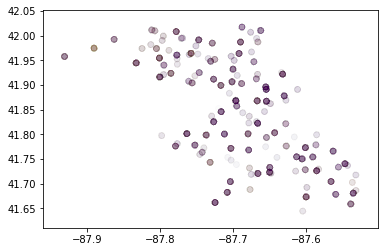

In [12]:
# look at dispersion of virus incidence geographically
plt.scatter(agg_train.Longitude, agg_train.Latitude, c = agg_train.WnvPresent, alpha = .01)

In [13]:
import math
# source: https://www.johndcook.com/blog/python_longitude_latitude/
def distance_on_unit_sphere(lat1, long1, lat2, long2):

    # Convert latitude and longitude to spherical coordinates in radians
    degrees_to_radians = math.pi/180.0

    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians

    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians

    # Compute spherical distance from spherical coordinates.

    # For two locations in spherical coordinates
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) =
    # sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length

    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) +
    math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )

    # Remember to multiply arc by the radius of the earth
    # in your favorite set of units to get length.
    return arc

In [14]:
# weather stations 1 and 2 lat/longitude
#Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
#Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level
station_1_lat = 41.995
station_1_lon = -87.933
station_2_lat = 41.786
station_2_lon = -87.752
# function to calculate whether station 1 or 2 (from weather.csv) is closer
def closest_station(lat, lon):
    if (distance_on_unit_sphere(lat, lon, station_1_lat, station_1_lon) <
        distance_on_unit_sphere(lat, lon, station_2_lat, station_2_lon)):
        return 1
    else: return 2
    
#source: Data Description
#Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
#Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [15]:
# add station to indicate whether station 1 or 2 is closer
#create unique variable to combine train and weather data
def station_var (data):
    data['Station'] = [closest_station(a,b) for (a, b) in zip(data.Latitude, data.Longitude)]
    data['unique'] =  data['Station'].astype(str) + str(": ") + data['Date'].astype(str)

In [16]:
station_var(agg_train)
station_var(test)

In [17]:
#create unique variable to combine train and weather data
weather['unique'] =  weather['Station'].astype(str) + str(": ") + weather['Date'].astype(str)

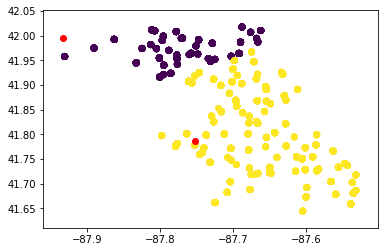

In [18]:
# look at dispersion of traps geographically
plt.scatter(agg_train.Longitude, agg_train.Latitude, c = agg_train.Station)
plt.scatter([station_1_lon, station_2_lon], [station_1_lat,station_2_lat], c = 'r')
plt.show()

In [19]:
combined_train = pd.merge (agg_train, weather, how="inner", on="unique")
combined_test = pd.merge (test, weather, how="inner", on="unique")

In [20]:
combined_train = combined_train.drop(["Date_y", "Station_x", "unique"], axis=1)
combined_test = combined_test.drop(["Date_y", "Station_x", "unique"], axis=1)

In [21]:
combined_train.head(30)

,Date_x,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Station_y,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Depth,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-29,T002,41.954690,-87.800991,2,0,1,88,60,74,10,58,65,0,9,0,30.11,5.8,18,6.5
1,2007-05-29,T148,42.017430,-87.687769,1,0,1,88,60,74,10,58,65,0,9,0,30.11,5.8,18,6.5
2,2007-05-29,T143,41.999129,-87.795585,1,0,1,88,60,74,10,58,65,0,9,0,30.11,5.8,18,6.5
3,2007-05-29,T015,41.974089,-87.824812,5,0,1,88,60,74,10,58,65,0,9,0,30.11,5.8,18,6.5
4,2007-05-29,T007,41.994991,-87.769279,1,0,1,88,60,74,10,58,65,0,9,0,30.11,5.8,18,6.5
5,2007-05-29,T159,41.732984,-87.649642,1,0,2,88,65,77,10,59,66,0,12,0,30.09,5.8,16,7.4
6,2007-05-29,T153,41.907645,-87.760886,1,0,2,88,65,77,10,59,66,0,12,0,30.09,5.8,16,7.4
7,2007-05-29,T129,41.891126,-87.611560,3,0,2,88,65,77,10,59,66,0,12,0,30.09,5.8,16,7.4
8,2007-05-29,T094,41.720848,-87.666014,3,0,2,88,65,77,10,59,66,0,12,0,30.09,5.8,16,7.4
9,2007-05-29,T091,41.862292,-87.648860,1,0,2,88,65,77,10,59,66,0,12,0,30.09,5.8,16,7.4


## Baseline

In [22]:
combined_train['WnvPresent'].mean()

0.08340554592720971

In [23]:
#Baseline classification- if we always guessed the mosquito does not carry a virus, what is the chance of correctly
#predicting?

1 - combined_train['WnvPresent'].mean()

0.9165944540727903

In [116]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, linear_model, datasets
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns



plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [25]:
X = combined_train.drop(["Latitude", "Longitude", "WnvPresent","Trap","Date_x"], axis=1)
y = combined_train.WnvPresent

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42)

In [27]:
class model_evaluation:
   
    def __init__(self, y_test, predicted_value):
        self.y_test = y_test
        self.predicted_value = predicted_value
        
    def confusion_matrix (self):
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.predicted_value).ravel()
        print("True Negatives: %s" % tn)
        print("False Positives: %s" % fp)
        print("False Negatives: %s" % fn)
        print("True Positives: %s" % tp)
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        print("Precision: {}" .format (tp/(tp+fp)))
        print("Recall: {}" .format (tp/(tp+fn)))
        F1_score = 2*((precision*recall)/(precision+recall))
        print ("F1 score: {}" .format(2*((precision*recall)/(precision+recall))))
        self.score = F1_score

In [28]:
lr_model = LogisticRegression()

In [29]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
predicted_lr = lr.predict(X_test)
lrg = model_evaluation (y_test,predicted_lr)
lrg.confusion_matrix ()

True Negatives: 1054
False Positives: 2
False Negatives: 90
True Positives: 8
Precision: 0.8
Recall: 0.08163265306122448
F1 score: 0.1481481481481481


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [31]:
X_train.head()

,NumMosquitos,Station_y,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Depth,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
1407,19,2,83,56,70,10,56,62,0,5,0,30.03,4.6,17,5.9
321,3,2,85,69,77,3,69,71,0,12,0,29.83,10.3,24,10.6
3687,4,2,83,68,76,4,60,65,0,11,0,29.62,9.0,29,9.8
3938,2,2,81,58,70,-5,52,60,0,5,0,30.05,2.7,23,3.9
1411,2,2,83,56,70,10,56,62,0,5,0,30.03,4.6,17,5.9


In [93]:
#Test code, scaling of data, reduction of dimensionality, use of SVC.
from sklearn.decomposition import PCA
from sklearn.svm import SVC
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=4)),
    ('clf', SVC(kernel = 'linear', C = 1))])
param_grid = dict(reduce_dims__n_components=[4,6,8],
                  clf__C=np.logspace(-4, 1, 6),
                  clf__kernel=['rbf','linear'])


grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
print(grid.score(X_test, y_test))


''' sample codes
#params={'model__C':[.01,.05,.1,.5,1,5,10],
           'model__penalty':['l1','l2']}
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=40,ngram_range=(1,4))),
    ('tfidf', TfidfTransformer()),
    ('model',LogisticRegression())])
grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params ,scoring='roc_auc')
grid.fit(train['text'], train['output'])
grid.score(test['text'], test['output'])


#pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=4)),
        ('clf', SVC(kernel = 'linear', C = 1))])

param_grid = dict(reduce_dims__n_components=[4,6,8],
                  clf__C=np.logspace(-4, 1, 6),
                  clf__kernel=['rbf','linear'])

grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=1, verbose=2, scoring= 'accuracy')
grid.fit(X, y)
print(grid.best_score_)
print(grid.cv_results_)
'''

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.0s


0.8074978232579905
{'mean_fit_time': array([0.07932944, 0.07777152, 0.07702451, 0.05205297, 0.05558639,
       0.0578598 , 0.07064877, 0.07842717, 0.09208078, 0.06459031,
       0.06507883, 0.07008309, 0.08084521, 0.08878875, 0.09069686,
       0.07589583, 0.08609934, 0.07494922, 0.10994215, 0.10585089,
       0.1045774 , 0.27678418, 0.3195868 , 0.15992146, 0.16270738,
       0.15031824, 0.12229443, 0.72690558, 0.86505475, 0.5677278 ,
       0.23193364, 0.15733743, 0.14617233, 6.0468204 , 6.56892796,
       3.81608577]), 'std_fit_time': array([4.31756701e-03, 3.02667072e-03, 2.93184828e-03, 3.43507142e-03,
       9.33283812e-04, 4.52206760e-03, 2.92185323e-03, 6.35750068e-03,
       6.20207057e-03, 1.11564910e-02, 4.21303721e-03, 5.57453748e-03,
       3.27826147e-03, 6.19919503e-03, 4.97307292e-03, 1.34792054e-02,
       5.18881628e-03, 3.66576684e-03, 3.49235343e-03, 7.87888820e-03,
       4.28508978e-03, 1.14705266e-01, 3.95758837e-02, 1.28901733e-02,
       3.18537127e-02, 3.283748

[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   34.3s finished
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


" sample codes\n#params={'model__C':[.01,.05,.1,.5,1,5,10],\n           'model__penalty':['l1','l2']}\npipeline = Pipeline([\n    ('vect', CountVectorizer(min_df=40,ngram_range=(1,4))),\n    ('tfidf', TfidfTransformer()),\n    ('model',LogisticRegression())])\ngrid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params ,scoring='roc_auc')\ngrid.fit(train['text'], train['output'])\ngrid.score(test['text'], test['output'])\n\n\n#pipe = Pipeline([\n        ('scale', StandardScaler()),\n        ('reduce_dims', PCA(n_components=4)),\n        ('clf', SVC(kernel = 'linear', C = 1))])\n\nparam_grid = dict(reduce_dims__n_components=[4,6,8],\n                  clf__C=np.logspace(-4, 1, 6),\n                  clf__kernel=['rbf','linear'])\n\ngrid = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=1, verbose=2, scoring= 'accuracy')\ngrid.fit(X, y)\nprint(grid.best_score_)\nprint(grid.cv_results_)\n"

In [94]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', SVC(kernel = 'linear', C = 1))])
param_grid = dict(clf__C=np.logspace(-4, 1, 6),
                  clf__kernel=['rbf','linear'])


grid = GridSearchCV(pipeline, cv=3, n_jobs=-1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
grid.score(X_test, y_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.8093893319883654
{'mean_fit_time': array([0.05301007, 0.05297709, 0.077751  , 0.0518709 , 0.07478905,
       0.0719893 , 0.09785636, 0.12660265, 0.09928258, 0.40840387,
       0.10716478, 1.90228287]), 'std_fit_time': array([0.00220532, 0.01394888, 0.00812387, 0.00322542, 0.00767105,
       0.00223826, 0.00260961, 0.02735259, 0.0135979 , 0.03847748,
       0.00310029, 0.14840976]), 'mean_score_time': array([0.02562888, 0.02078136, 0.02755658, 0.02122808, 0.03262027,
       0.01986837, 0.03266374, 0.01557199, 0.03193005, 0.01369905,
       0.03028933, 0.01139784]), 'std_score_time': array([0.001035  , 0.00729268, 0.00282022, 0.00377171, 0.00539678,
       0.00191956, 0.00305754, 0.00064934, 0.00224445, 0.00225455,
       0.00311866, 0.00136449]), 'param_clf__C': masked_array(data=[0.0001, 0.0001, 0.001, 0.001, 0.01, 0.01, 0.1, 0.1,
                   1.0, 1.0, 10.0, 10.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False

[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    5.5s finished
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

0.8584183673469388

In [95]:
grid.best_params_

{'clf__C': 10.0, 'clf__kernel': 'rbf'}

In [97]:
#KNN
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=4)),
    ('clf', KNeighborsClassifier())])
param_grid = dict(reduce_dims__n_components=[4,6,8],
                  clf__n_neighbors=range(1, 201, 10),
                  clf__metric=['euclidean', 'manhattan'])


grid = GridSearchCV(pipeline, cv=3, n_jobs=-1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
grid.score(X_test, y_test)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:   18.5s


0.8283900144896919
{'mean_fit_time': array([0.02052967, 0.022729  , 0.01929696, 0.01759871, 0.03033042,
       0.0174466 , 0.022976  , 0.03448606, 0.01810964, 0.02222228,
       0.02044646, 0.01900498, 0.02023427, 0.01560648, 0.01732032,
       0.01775638, 0.01824323, 0.0166777 , 0.01544841, 0.01584856,
       0.01716089, 0.01544237, 0.01994133, 0.01839836, 0.01673261,
       0.01848833, 0.02020693, 0.02067916, 0.0163703 , 0.02603706,
       0.01870418, 0.01742665, 0.01648299, 0.02009233, 0.01681924,
       0.01733971, 0.02550681, 0.02806234, 0.01834695, 0.01739995,
       0.01807396, 0.02067232, 0.03086925, 0.03091399, 0.03888067,
       0.01734535, 0.01759036, 0.01657192, 0.01671537, 0.02244504,
       0.01795499, 0.02035141, 0.01770926, 0.0174377 , 0.02489956,
       0.01637673, 0.01870108, 0.01916234, 0.01814477, 0.01696976,
       0.03291289, 0.02606932, 0.03091431, 0.02799932, 0.02256552,
       0.02481564, 0.03282261, 0.02847155, 0.02876838, 0.0285097 ,
       0.02640231, 0.0242

[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   28.6s finished
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.8400732452071737

In [98]:
grid.best_params_

{'clf__metric': 'manhattan',
 'clf__n_neighbors': 11,
 'reduce_dims__n_components': 8}

In [99]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', KNeighborsClassifier())])
param_grid = dict(clf__n_neighbors=range(1, 201, 10),
                  clf__metric=['euclidean', 'manhattan'])


grid = GridSearchCV(pipeline, cv=3, n_jobs=-1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
grid.score(X_test, y_test)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    9.0s


0.8395339007903024
{'mean_fit_time': array([0.00968877, 0.01115815, 0.0110058 , 0.01579706, 0.00943756,
       0.01154955, 0.01068393, 0.01282899, 0.01015337, 0.01022212,
       0.01012707, 0.01111635, 0.01110228, 0.01080068, 0.00961526,
       0.0098962 , 0.02317882, 0.00975577, 0.01045895, 0.01332005,
       0.01718148, 0.01002955, 0.01103981, 0.0102311 , 0.0441796 ,
       0.0272452 , 0.01047707, 0.01395567, 0.01339507, 0.01120694,
       0.01093626, 0.01088397, 0.02183064, 0.01048867, 0.00999999,
       0.01328707, 0.00908637, 0.0099419 , 0.01062957, 0.01135739]), 'std_fit_time': array([0.00154953, 0.00222418, 0.00161834, 0.00280549, 0.00020545,
       0.00315762, 0.00083808, 0.00359115, 0.00020677, 0.00074118,
       0.00111982, 0.00161468, 0.0014355 , 0.00175045, 0.00017926,
       0.00043482, 0.01790035, 0.00054774, 0.00041338, 0.00291704,
       0.010714  , 0.00022975, 0.00078274, 0.00084556, 0.04845821,
       0.01623425, 0.00089169, 0.00169209, 0.00252756, 0.00155898,
       

[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   17.6s finished
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.8560944264069265

In [100]:
grid.best_params_

{'clf__metric': 'manhattan', 'clf__n_neighbors': 21}

In [103]:
#Multinomial is not applicable here due to the need for vectorizing, Decision trees will be used
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=4)),
    ('clf', DecisionTreeClassifier())])
param_grid = dict(reduce_dims__n_components=[4,6,8],
                  clf__max_depth=[None,1,2,3,4,5],
                  clf__max_features=['sqrt', 'log2', None],
                  clf__min_samples_split=[2,3,4,5,10,15,20,25,30,40,50])


grid = GridSearchCV(pipeline, cv=3, n_jobs=-1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
grid.score(X_test, y_test)


'''
n_params = {
    'max_depth': [None,1,2,3,4,5],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2,3,4,5,10,15,20,25,30,40,50]
    }

grid3 = GridSearchCV(DecisionTreeClassifier(), n_params, cv=5)
grid3.fit(X,y)
print ('best score = {}'.format(grid3.best_score_))
grid3.best_params_
'''


Fitting 3 folds for each of 594 candidates, totalling 1782 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 884 tasks      | elapsed:   10.0s


0.8011170513983052
{'mean_fit_time': array([0.02273893, 0.03650737, 0.0209833 , 0.02465955, 0.02158602,
       0.02874438, 0.02279528, 0.02995133, 0.02379775, 0.02181967,
       0.02923266, 0.02931698, 0.02471391, 0.02693558, 0.02633421,
       0.02280966, 0.02761094, 0.02230906, 0.02358818, 0.0381976 ,
       0.02788599, 0.04769707, 0.02867985, 0.05691616, 0.02293738,
       0.04179994, 0.03306866, 0.02073979, 0.02540374, 0.02097329,
       0.02012134, 0.02144368, 0.02347279, 0.02274768, 0.02767452,
       0.02733962, 0.02412033, 0.02385227, 0.02827271, 0.02117491,
       0.02405604, 0.02403243, 0.02139839, 0.03131906, 0.03750666,
       0.03860561, 0.02654441, 0.03549631, 0.02975742, 0.0254391 ,
       0.03000863, 0.01975036, 0.02089802, 0.02406335, 0.02010338,
       0.02044606, 0.02390965, 0.02074496, 0.02401694, 0.0312326 ,
       0.03115273, 0.02618535, 0.03474402, 0.02640104, 0.03080368,
       0.03211355, 0.03650379, 0.05254873, 0.06136616, 0.0444537 ,
       0.04703871, 0.0615

[Parallel(n_jobs=-1)]: Done 1782 out of 1782 | elapsed:   21.5s finished
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


"\nn_params = {\n    'max_depth': [None,1,2,3,4,5],\n    'max_features': ['sqrt', 'log2', None],\n    'min_samples_split': [2,3,4,5,10,15,20,25,30,40,50]\n    }\n\ngrid3 = GridSearchCV(DecisionTreeClassifier(), n_params, cv=5)\ngrid3.fit(X,y)\nprint ('best score = {}'.format(grid3.best_score_))\ngrid3.best_params_\n"

In [104]:
grid.best_params_

{'clf__max_depth': None,
 'clf__max_features': 'sqrt',
 'clf__min_samples_split': 50,
 'reduce_dims__n_components': 8}

In [ ]:
list_2 = zip(list(X.columns), list(grid.best_estimator_.steps[2][1].feature_importances_))
pl = pd.Series(dict(list_2)).sort_values(ascending=False)
pl

In [105]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', DecisionTreeClassifier())])
param_grid = dict(clf__max_depth=[None,1,2,3,4,5],
                  clf__max_features=['sqrt', 'log2', None],
                  clf__min_samples_split=[2,3,4,5,10,15,20,25,30,40,50])


grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
print(grid.score(X_test, y_test))

Fitting 5 folds for each of 198 candidates, totalling 990 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    2.0s


0.8322733259574125
{'mean_fit_time': array([0.01235504, 0.01084514, 0.01491342, 0.02121105, 0.01542168,
       0.01251373, 0.01464882, 0.02194147, 0.01865125, 0.01140327,
       0.01096539, 0.0147768 , 0.01662641, 0.01496172, 0.01185608,
       0.01179967, 0.01431818, 0.01486955, 0.01079278, 0.0114387 ,
       0.01931443, 0.0107748 , 0.02207713, 0.0210659 , 0.01903958,
       0.01915445, 0.02108712, 0.0217123 , 0.01845303, 0.0209084 ,
       0.01899981, 0.01832452, 0.01759744, 0.01419582, 0.01275325,
       0.01491532, 0.01282678, 0.01481061, 0.01025243, 0.01441307,
       0.01461625, 0.01686592, 0.0142314 , 0.01201859, 0.01219487,
       0.01228576, 0.01084766, 0.01336226, 0.01191478, 0.01398182,
       0.01070604, 0.01180224, 0.01212101, 0.00940623, 0.01108899,
       0.02587667, 0.01077299, 0.03152699, 0.02606964, 0.03819175,
       0.02419319, 0.01333237, 0.0257679 , 0.01261272, 0.01301188,
       0.01239572, 0.01080532, 0.00985184, 0.00958581, 0.00890284,
       0.01149826, 0.0106

[Parallel(n_jobs=-1)]: Done 990 out of 990 | elapsed:    7.7s finished
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [106]:
grid.best_params_

{'clf__max_depth': 3, 'clf__max_features': None, 'clf__min_samples_split': 2}

In [110]:
#Example of feature importance: grid.best_estimator_.steps[1][1].feature_importances_
list_2 = zip(list(X.columns), list(grid.best_estimator_.steps[1][1].feature_importances_))
pl = pd.Series(dict(list_2)).sort_values(ascending=False)
pl.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

NumMosquitos    0.798267
Cool            0.134609
SeaLevel        0.043210
DewPoint        0.023914
AvgSpeed        0.000000
ResultDir       0.000000
ResultSpeed     0.000000
Depth           0.000000
Heat            0.000000
WetBulb         0.000000
Depart          0.000000
Tavg            0.000000
Tmin            0.000000
Tmax            0.000000
Station_y       0.000000
dtype: float64

In [125]:
#Random forest- of course we need a random search first yeah?
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
'''
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
'''

# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rc = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rc_random = RandomizedSearchCV(estimator = rc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model


pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=4)),
    ('clf', RandomForestClassifier(random_state=42))])
param_grid = dict(reduce_dims__n_components=[4,6,8],
                  clf__n_estimators=[int(x) for x in np.linspace(200, 2000, 10)],
                  clf__max_features=['auto', 'sqrt'],
                  clf__max_depth=max_depth,
                  clf__min_samples_split=[2, 5, 10],
                  clf__min_samples_leaf=[1, 2, 4],
                  clf__bootstrap=[True, False]
                 )


rc_random = RandomizedSearchCV(pipeline, cv=3, n_jobs=-1, param_distributions=param_grid, n_iter = 100, verbose=2, scoring='roc_auc', random_state=42)
rc_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.9min finished
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reduce_dims', PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
     ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'reduce_dims__n_components': [4, 6, 8], 'clf__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'clf__max_features': ['auto', 'sqrt'], 'clf__max_depth': [10, 21, 32, 43, 54, 65, 76, 87, 98, 110, None], 'clf__min_samples_split': [2, 5, 10], 'clf__min_samples_leaf': [1, 2, 4], 'clf__bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,

In [127]:
rc_random.best_params_

{'reduce_dims__n_components': 8,
 'clf__n_estimators': 800,
 'clf__min_samples_split': 10,
 'clf__min_samples_leaf': 2,
 'clf__max_features': 'auto',
 'clf__max_depth': 10,
 'clf__bootstrap': True}

In [131]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=8)),
    ('clf', RandomForestClassifier(max_features='auto', bootstrap=True, min_samples_leaf=2,random_state=42))])

param_grid = dict(clf__n_estimators=[700, 800, 900],
                  clf__max_depth=[7,9,11,13],
                  clf__min_samples_split=[8,10,12,14],
                 )


grid = GridSearchCV(pipeline, cv=3, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
grid.score(X_test, y_test)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4, total=   1.8s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4, total=   1.9s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.2s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.0s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6, total=   1.9s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.3s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8, total=   1.8s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8, total=   1.9s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.2s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.5s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.3s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.5s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.4s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.4s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.3s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.2s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.0s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.1s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4, total=   2.7s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4, total=   3.0s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4, total=   2.6s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.1s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.3s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.2s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8, total=   2.7s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8, total=   2.7s
[CV] clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8, total=   2.5s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.1s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.0s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.0s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6, total=   1.9s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.0s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.2s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.0s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8, total=   1.9s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8, total=   1.9s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.3s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.3s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.2s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.3s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.1s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.1s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.5s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.4s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.4s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4, total=   2.8s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4, total=   2.6s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4, total=   2.9s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6, total=   2.9s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.0s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.0s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8, total=   2.5s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8, total=   2.4s
[CV] clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8, total=   2.4s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.1s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.0s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.2s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.3s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.1s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.0s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.1s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.2s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.0s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.2s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.4s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.3s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6, total=   3.3s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6, total=   3.6s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6, total=   3.5s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8, total=   3.1s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.9s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8, total=   3.3s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4, total=   3.6s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4, total=   3.8s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4, total=   3.4s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.3s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.1s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.2s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8, total=   3.3s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8, total=   2.9s
[CV] clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8, total=   3.3s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.4s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.5s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.6s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.6s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.5s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.8s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.6s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.4s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.5s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4, total=   3.1s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.9s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.8s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6, total=   3.0s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.8s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6, total=   3.3s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8, total=   3.0s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.7s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8, total=   3.2s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4, total=   3.9s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4, total=   3.7s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4, total=   3.2s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.9s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.8s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.7s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8, total=   3.1s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8, total=   3.3s
[CV] clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8, total=   4.1s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4, total=   3.2s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.8s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.8s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6, total=   3.4s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.9s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6, total=   3.1s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.9s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8, total=   3.9s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4, total=   3.5s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4, total=   3.8s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4, total=   3.9s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6, total=   3.5s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6, total=   3.7s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6, total=   3.5s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8, total=   3.1s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.9s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8, total=   3.5s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4, total=   3.9s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4, total=   3.7s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4, total=   3.7s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.7s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.6s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.7s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8, total=   3.7s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8, total=   3.5s
[CV] clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8, total=   3.7s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input

[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.8s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.8s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.8s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6, total=   3.1s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6, total=   3.0s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8, total=   3.2s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8, total=   4.3s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.8s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.4s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.4s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.4s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4, total=   2.9s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4, total=   2.8s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4, total=   2.9s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6, total=   2.8s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6, total=   2.9s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8, total=   3.0s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.3s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.0s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.0s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.1s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6, total=   1.9s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.1s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.1s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.0s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.1s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.2s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.2s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.3s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.3s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.0s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4, total=   1.9s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.0s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.1s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6, total=   1.9s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.0s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8, total=   1.9s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8, total=   1.9s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8, total=   1.9s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.3s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.9s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4, total=   2.8s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6, total=   2.9s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8, total=   2.9s
[CV] clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8, total=   2.9s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.2s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.4s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6, total=   3.1s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8, total=   3.0s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4, total=   2.9s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4, total=   2.8s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4, total=   2.8s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.0s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.0s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.3s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8, total=   3.1s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8, total=   3.1s
[CV] clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8, total=   3.0s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.1s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.1s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.1s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.1s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.1s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.2s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.1s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.0s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.1s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4, total=   3.0s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6, total=   3.0s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.8s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8, total=   3.0s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.4s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.4s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4, total=   2.9s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4, total=   2.9s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4, total=   3.4s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.4s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.1s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6, total=   2.8s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8, total=   2.9s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.2s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.3s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.2s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.2s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.3s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.3s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.4s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.1s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.1s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.4s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.4s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.8s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.8s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4, total=   3.3s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4, total=   2.9s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4, total=   2.9s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.5s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6, total=   4.1s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.0s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8, total=   3.1s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8, total=   2.8s
[CV] clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8, total=   2.9s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.1s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.0s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.2s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.1s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.1s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.3s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.4s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.2s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.2s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4, total=   3.2s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4, total=   3.7s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.8s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4, total=   4.0s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4, total=   3.7s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4, total=   4.4s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.6s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.2s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6, total=   4.6s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8, total=   5.1s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8, total=   4.0s
[CV] clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8, total=   3.7s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.5s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.5s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.6s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6, total=   3.2s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.6s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.5s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.4s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.5s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.9s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=4, total=   2.9s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.9s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.7s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=800, reduce_dims__n_components=8, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4, total=   3.3s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4, total=   3.8s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=4, total=   3.1s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.2s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.1s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.4s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8, total=   3.2s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8, total=   3.0s
[CV] clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=8, clf__n_estimators=900, reduce_dims__n_components=8, total=   3.2s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.5s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.4s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.5s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6, total=   3.3s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6, total=   3.2s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.7s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.9s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=700, reduce_dims__n_components=8, total=   3.2s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4, total=   3.5s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4, total=   3.4s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=4, total=   3.6s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6, total=   3.6s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6, total=   3.4s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=6, total=   3.3s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8, total=   3.6s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8, total=   3.4s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=800, reduce_dims__n_components=8, total=   3.3s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4, total=   3.5s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4, total=   3.1s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=4, total=   3.7s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.2s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.0s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.7s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8, total=   4.4s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8, total=   3.7s
[CV] clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=10, clf__n_estimators=900, reduce_dims__n_components=8, total=   3.8s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.7s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.5s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=4, total=   2.6s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.9s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.6s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.7s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.3s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=700, reduce_dims__n_components=8, total=   3.5s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4, total=   4.1s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4, total=   3.6s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=4, total=   4.3s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6, total=   3.2s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.7s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=6, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8, total=   3.4s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8, total=   3.5s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=800, reduce_dims__n_components=8, total=   4.0s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4, total=   4.9s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4, total=   4.0s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=4, total=   3.1s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6, total=   3.8s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6, total=   4.4s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=6, total=   4.4s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8, total=   4.1s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8, total=   3.6s
[CV] clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=12, clf__n_estimators=900, reduce_dims__n_components=8, total=   3.7s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4, total=   3.2s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4, total=   3.3s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=4, total=   3.1s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6, total=   3.0s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6, total=   2.9s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=6, total=   3.2s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8, total=   3.1s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=700, reduce_dims__n_components=8, total=   3.2s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4, total=   3.8s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4, total=   4.0s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=4, total=   5.2s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6, total=   3.9s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6, total=   4.9s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=6, total=   4.1s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8, total=   4.1s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8, total=   3.9s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=800, reduce_dims__n_components=8, total=   3.8s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4, total=   4.9s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4, total=   4.3s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=4, total=   4.4s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6, total=   4.9s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6, total=   4.4s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=6, total=   4.6s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8, total=   4.3s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8, total=   4.2s
[CV] clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_split=14, clf__n_estimators=900, reduce_dims__n_components=8, total=   4.1s


[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed: 22.9min finished
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0.8567722451952032
{'mean_fit_time': array([1.84758965, 1.92411033, 1.81805134, 2.27077317, 2.20123204,
       1.94162734, 2.58676569, 3.01809398, 2.4757843 , 1.88748288,
       1.88666765, 1.80609131, 2.11152744, 2.0344522 , 2.30109739,
       2.59418178, 2.76499073, 2.30958533, 1.97519628, 1.9750332 ,
       1.93861969, 2.14485598, 3.24061807, 2.867275  , 3.37157822,
       2.99289727, 2.91744391, 2.37700407, 2.40533964, 2.35062702,
       2.74310907, 2.69405778, 2.78192814, 3.39529101, 3.52941744,
       3.26045879, 2.76361012, 2.95112999, 2.8959837 , 3.5162967 ,
       3.32592996, 2.97186001, 3.53221742, 3.4243257 , 3.41122667,
       2.63097366, 2.72618508, 3.20527689, 2.44341413, 2.39366627,
       2.31171131, 2.64304797, 2.64807343, 2.55640705, 1.96984323,
       1.91641132, 1.93507687, 2.19993099, 2.2908686 , 2.48575473,
       2.39818772, 2.41442585, 2.36092186, 1.85392102, 1.88611301,
       1.80561201, 2.34758472, 2.4964122 , 2.37101436, 2.48821298,
       2.52520776, 2.6525

/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.8846243042671613

In [132]:
grid.best_params_

{'clf__max_depth': 9,
 'clf__min_samples_split': 14,
 'clf__n_estimators': 800,
 'reduce_dims__n_components': 8}

In [ ]:
list_2 = zip(list(X.columns), list(grid.best_estimator_.steps[2][1].feature_importances_))
pl = pd.Series(dict(list_2)).sort_values(ascending=False)
pl.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [133]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
'''
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
'''

# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rc = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rc_random = RandomizedSearchCV(estimator = rc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model


pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))])
param_grid = dict(clf__n_estimators=[int(x) for x in np.linspace(200, 2000, 10)],
                  clf__max_features=['auto', 'sqrt'],
                  clf__max_depth=max_depth,
                  clf__min_samples_split=[2, 5, 10],
                  clf__min_samples_leaf=[1, 2, 4],
                  clf__bootstrap=[True, False]
                 )


rc_random = RandomizedSearchCV(pipeline, cv=3, n_jobs=-1, param_distributions=param_grid, n_iter = 100, verbose=2, scoring='roc_auc', random_state=42)
rc_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.5min finished
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
      ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'clf__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'clf__max_features': ['auto', 'sqrt'], 'clf__max_depth': [10, 21, 32, 43, 54, 65, 76, 87, 98, 110, None], 'clf__min_samples_split': [2, 5, 10], 'clf__min_samples_leaf': [1, 2, 4], 'clf__bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', sc

In [134]:
rc_random.best_params_

{'clf__n_estimators': 1400,
 'clf__min_samples_split': 5,
 'clf__min_samples_leaf': 4,
 'clf__max_features': 'sqrt',
 'clf__max_depth': 10,
 'clf__bootstrap': True}

In [135]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', RandomForestClassifier(max_features='sqrt', bootstrap=True,random_state=42))])

param_grid = dict(clf__n_estimators=[1300, 1400, 1500],
                  clf__max_depth=[7,9,11,13],
                  clf__min_samples_split=[4,5,6],
                  clf__min_samples_leaf=[4,6,8]
                 )


grid = GridSearchCV(pipeline, cv=3, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
grid.score(X_test, y_test)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.3s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.4s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.4s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.8s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.6s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.6s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500, total=   4.4s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500, total=   5.4s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500, total=   5.2s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300, total=   3.3s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300, total=   3.0s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300, total=   3.4s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400, total=   3.6s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400, total=   3.5s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400, total=   5.7s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500, total=   4.6s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500, total=   3.6s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500, total=   3.7s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300, total=   3.0s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.9s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300, total=   3.0s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400, total=   3.2s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400, total=   3.1s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400, total=   3.1s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500, total=   3.3s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500, total=   3.3s
[CV] clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500, total=   3.3s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300, total=   3.1s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.8s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300, total=   3.2s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400, total=   3.4s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400, total=   3.4s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400, total=   3.0s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500, total=   3.1s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500, total=   3.1s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500, total=   3.3s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.7s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.7s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.9s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400, total=   3.2s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400, total=   3.4s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400, total=   3.2s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500, total=   3.9s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500, total=   3.1s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500, total=   3.1s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300, total=   4.8s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300, total=   4.4s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300, total=   3.5s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400, total=   3.5s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400, total=   3.5s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400, total=   3.4s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500, total=   3.6s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500, total=   3.5s
[CV] clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500, total=   3.4s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300, total=   3.3s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.9s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300, total=   3.2s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400, total=   3.5s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400, total=   3.5s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400, total=   3.6s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500, total=   3.9s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500, total=   3.7s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500, total=   3.9s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300, total=   3.3s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300, total=   3.2s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300, total=   3.4s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400, total=   3.7s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400, total=   3.5s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400, total=   3.4s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500, total=   4.4s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500, total=   3.9s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500, total=   3.7s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300, total=   4.4s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300, total=   3.2s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300, total=   3.2s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400, total=   3.4s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400, total=   3.5s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400, total=   3.4s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500, total=   5.3s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500, total=   3.1s
[CV] clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=7, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500, total=   3.1s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.9s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.3s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.3s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.2s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400, total=   2.8s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400, total=   2.8s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500, total=   2.8s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500, total=   2.9s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300, total=   3.0s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500, total=   2.9s
[CV] clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.3s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300, total=   3.4s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.8s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.9s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500, total=   2.8s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.4s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.9s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300, total=   3.0s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400, total=   3.2s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500, total=   3.0s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500, total=   3.0s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500, total=   2.9s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.4s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.4s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.4s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.4s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.3s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500, total=   2.8s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500, total=   3.0s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500, total=   3.0s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300, total=   3.1s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400, total=   2.8s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500, total=   3.0s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500, total=   2.9s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500, total=   3.2s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.4s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.3s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.8s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.7s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.5s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500, total=   2.8s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500, total=   2.6s
[CV] clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=9, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500, total=   2.8s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500, total=   3.1s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500, total=   2.9s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400, total=   2.8s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500, total=   2.8s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500, total=   2.8s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500, total=   2.9s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.8s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500, total=   3.0s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500, total=   2.9s
[CV] clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500, total=   2.9s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.4s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500, total=   2.8s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500, total=   3.4s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500, total=   3.9s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500, total=   2.9s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.4s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.3s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.3s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500, total=   2.9s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500, total=   2.9s
[CV] clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500, total=   2.9s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.9s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500, total=   3.1s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500, total=   2.8s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500, total=   2.8s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.4s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.4s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500, total=   2.8s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500, total=   2.7s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.4s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400, total=   3.0s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.6s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500, total=   3.0s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500, total=   3.6s
[CV] clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=11, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500, total=   3.3s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.9s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.7s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.9s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.7s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500, total=   3.5s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=4, clf__n_estimators=1500, total=   3.1s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.6s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.9s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.7s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400, total=   3.1s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500, total=   3.3s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500, total=   3.4s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1500, total=   3.2s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.6s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.9s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.7s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500, total=   3.0s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500, total=   3.0s
[CV] clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=4, clf__min_samples_split=6, clf__n_estimators=1500, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.6s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.7s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.7s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500, total=   2.9s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500, total=   3.0s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=4, clf__n_estimators=1500, total=   3.0s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.4s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.6s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.6s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400, total=   2.7s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1400, total=   2.7s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500, total=   3.0s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=5, clf__n_estimators=1500, total=   3.0s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.4s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.6s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.6s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.7s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=6, clf__min_samples_split=6, clf__n_estimators=1500, total=   3.0s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.4s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.3s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1300, total=   2.6s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.6s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.7s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1400, total=   2.6s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500, total=   2.7s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=1500, total=   2.9s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.9s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.7s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1300, total=   2.9s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400, total=   3.2s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400, total=   3.1s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1400, total=   3.2s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500, total=   2.9s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=1500, total=   2.9s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1300, total=   2.5s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.8s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.6s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1400, total=   2.5s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500, total=   2.7s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500, total=   2.7s
[CV] clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500 


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV]  clf__max_depth=13, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=1500, total=   2.8s


[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed: 18.2min finished
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0.8829816924284161
{'mean_fit_time': array([2.13310695, 2.36179169, 4.40501444, 2.83022006, 3.81698227,
       3.51840933, 2.66342433, 2.81217853, 2.96696798, 2.72636533,
       2.9119006 , 2.88137205, 2.46369696, 2.95109288, 3.02191631,
       3.67404803, 3.09555888, 3.1896131 , 2.76657661, 3.15038006,
       3.43992106, 2.95646493, 3.2063152 , 3.49236147, 3.26915669,
       3.05953797, 3.56498837, 2.42993156, 2.36260271, 2.38303431,
       2.02175355, 2.42542704, 2.46591298, 2.47141663, 2.30713399,
       2.48486026, 2.54831727, 2.34922711, 2.44170141, 2.36667736,
       2.51340405, 2.58270812, 2.17073433, 2.27573975, 2.42158302,
       2.10271629, 2.24366331, 2.62696942, 2.42974941, 2.40313768,
       2.71852446, 2.20840732, 2.38848877, 2.4448808 , 2.26987998,
       2.38356352, 2.61266963, 2.22413866, 2.43056361, 2.56146661,
       2.35409331, 2.48219482, 2.6341881 , 2.22679162, 2.28280505,
       2.96093639, 2.29670016, 2.30173262, 2.48671802, 2.11944429,
       2.40201108, 2.5894

/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.8946834415584416

In [136]:
grid.best_params_

{'clf__max_depth': 7,
 'clf__min_samples_leaf': 6,
 'clf__min_samples_split': 5,
 'clf__n_estimators': 1300}

In [ ]:
list_2 = zip(list(X.columns), list(grid.best_estimator_.steps[1][1].feature_importances_))
pl = pd.Series(dict(list_2)).sort_values(ascending=False)
pl.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [150]:
from sklearn.ensemble import AdaBoostClassifier

pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=4)),
    ('clf', AdaBoostClassifier(random_state=42))])
param_grid = dict(reduce_dims__n_components=[4,6,8],
                  clf__n_estimators=[150, 200],
                  clf__learning_rate=[0.01,0.05,0.1,0.3,1],
                 )


ad_random = RandomizedSearchCV(pipeline, cv=3, n_jobs=-1, param_distributions=param_grid, n_iter = 100, verbose=2, scoring='roc_auc', random_state=42)
ad_random.fit(X_train, y_train)


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 30 is smaller than n_iter=100. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   25.3s finished
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reduce_dims', PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'reduce_dims__n_components': [4, 6, 8], 'clf__n_estimators': [150, 200], 'clf__learning_rate': [0.01, 0.05, 0.1, 0.3, 1]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=2)

In [151]:
ad_random.best_params_

{'reduce_dims__n_components': 6,
 'clf__n_estimators': 200,
 'clf__learning_rate': 0.3}

In [152]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=6)),
    ('clf', AdaBoostClassifier(random_state=42))])

param_grid = dict(clf__n_estimators=[200,250],
                  clf__learning_rate=[0.1,0.2,0.25,0.3,0.35]
                 )


grid = GridSearchCV(pipeline, cv=3, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
grid.score(X_test, y_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] clf__learning_rate=0.1, clf__n_estimators=200 ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
[Parallel(n_jobs=1)]: Done   1 o

[CV] .... clf__learning_rate=0.1, clf__n_estimators=200, total=   0.6s
[CV] clf__learning_rate=0.1, clf__n_estimators=200 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.1, clf__n_estimators=200, total=   0.5s
[CV] clf__learning_rate=0.1, clf__n_estimators=200 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.1, clf__n_estimators=200, total=   0.6s
[CV] clf__learning_rate=0.1, clf__n_estimators=250 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV] .... clf__learning_rate=0.1, clf__n_estimators=250, total=   0.8s
[CV] clf__learning_rate=0.1, clf__n_estimators=250 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data 

[CV] .... clf__learning_rate=0.1, clf__n_estimators=250, total=   1.0s
[CV] clf__learning_rate=0.1, clf__n_estimators=250 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.1, clf__n_estimators=250, total=   0.7s
[CV] clf__learning_rate=0.2, clf__n_estimators=200 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.2, clf__n_estimators=200, total=   0.6s
[CV] clf__learning_rate=0.2, clf__n_estimators=200 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.2, clf__n_estimators=200, total=   0.6s
[CV] clf__learning_rate=0.2, clf__n_estimators=200 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.2, clf__n_estimators=200, total=   0.7s
[CV] clf__learning_rate=0.2, clf__n_estimators=250 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.2, clf__n_estimators=250, total=   0.9s
[CV] clf__learning_rate=0.2, clf__n_estimators=250 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.2, clf__n_estimators=250, total=   0.8s
[CV] clf__learning_rate=0.2, clf__n_estimators=250 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.2, clf__n_estimators=250, total=   0.8s
[CV] clf__learning_rate=0.25, clf__n_estimators=200 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ... clf__learning_rate=0.25, clf__n_estimators=200, total=   0.6s
[CV] clf__learning_rate=0.25, clf__n_estimators=200 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ... clf__learning_rate=0.25, clf__n_estimators=200, total=   0.6s
[CV] clf__learning_rate=0.25, clf__n_estimators=200 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ... clf__learning_rate=0.25, clf__n_estimators=200, total=   0.6s
[CV] clf__learning_rate=0.25, clf__n_estimators=250 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ... clf__learning_rate=0.25, clf__n_estimators=250, total=   0.7s
[CV] clf__learning_rate=0.25, clf__n_estimators=250 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ... clf__learning_rate=0.25, clf__n_estimators=250, total=   0.7s
[CV] clf__learning_rate=0.25, clf__n_estimators=250 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ... clf__learning_rate=0.25, clf__n_estimators=250, total=   0.7s
[CV] clf__learning_rate=0.3, clf__n_estimators=200 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.3, clf__n_estimators=200, total=   0.6s
[CV] clf__learning_rate=0.3, clf__n_estimators=200 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.3, clf__n_estimators=200, total=   0.6s
[CV] clf__learning_rate=0.3, clf__n_estimators=200 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.3, clf__n_estimators=200, total=   0.6s
[CV] clf__learning_rate=0.3, clf__n_estimators=250 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.3, clf__n_estimators=250, total=   0.7s
[CV] clf__learning_rate=0.3, clf__n_estimators=250 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.3, clf__n_estimators=250, total=   0.7s
[CV] clf__learning_rate=0.3, clf__n_estimators=250 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.3, clf__n_estimators=250, total=   0.8s
[CV] clf__learning_rate=0.35, clf__n_estimators=200 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ... clf__learning_rate=0.35, clf__n_estimators=200, total=   0.6s
[CV] clf__learning_rate=0.35, clf__n_estimators=200 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ... clf__learning_rate=0.35, clf__n_estimators=200, total=   0.6s
[CV] clf__learning_rate=0.35, clf__n_estimators=200 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV] ... clf__learning_rate=0.35, clf__n_estimators=200, total=   0.7s
[CV] clf__learning_rate=0.35, clf__n_estimators=250 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV] ... clf__learning_rate=0.35, clf__n_estimators=250, total=   1.1s
[CV] clf__learning_rate=0.35, clf__n_estimators=250 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV] ... clf__learning_rate=0.35, clf__n_estimators=250, total=   1.2s
[CV] clf__learning_rate=0.35, clf__n_estimators=250 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   25.1s finished
/Users/evan/anaconda3/lib/python3.7/site-pa

[CV] ... clf__learning_rate=0.35, clf__n_estimators=250, total=   1.0s
0.8344761257085097
{'mean_fit_time': array([0.51807324, 0.756785  , 0.57307585, 0.78122775, 0.54692499,
       0.67087595, 0.5425419 , 0.70198917, 0.60732357, 1.01642036]), 'std_fit_time': array([0.01584847, 0.09797382, 0.02272696, 0.04855225, 0.01099547,
       0.00704826, 0.02083023, 0.04182413, 0.03240998, 0.07303536]), 'mean_score_time': array([0.05022987, 0.07453132, 0.04708012, 0.06555462, 0.04957032,
       0.05813678, 0.04774245, 0.07057786, 0.06241504, 0.09878198]), 'std_score_time': array([0.00372636, 0.01287852, 0.00040291, 0.00619604, 0.00168054,
       0.00102671, 0.0010067 , 0.01303515, 0.00863779, 0.02986988]), 'param_clf__learning_rate': masked_array(data=[0.1, 0.1, 0.2, 0.2, 0.25, 0.25, 0.3, 0.3, 0.35, 0.35],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_clf__n_estimators': masked_

/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.8361404220779222

In [153]:
grid.best_params_

{'clf__learning_rate': 0.25, 'clf__n_estimators': 250}

In [ ]:
list_2 = zip(list(X.columns), list(grid.best_estimator_.steps[2][1].feature_importances_))
pl = pd.Series(dict(list_2)).sort_values(ascending=False)
pl.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [154]:
#Adaboost without PCA
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', AdaBoostClassifier(random_state=42))])
param_grid = dict(clf__n_estimators=[150, 200],
                  clf__learning_rate=[0.01,0.05,0.1,0.3,1],
                 )


ad_random = RandomizedSearchCV(pipeline, cv=3, n_jobs=-1, param_distributions=param_grid, n_iter = 100, verbose=2, scoring='roc_auc', random_state=42)
ad_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.6s finished
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'clf__n_estimators': [150, 200], 'clf__learning_rate': [0.01, 0.05, 0.1, 0.3, 1]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=2)

In [155]:
ad_random.best_params_

{'clf__n_estimators': 200, 'clf__learning_rate': 0.3}

In [156]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', AdaBoostClassifier(random_state=42))])

param_grid = dict(clf__n_estimators=[200,250],
                  clf__learning_rate=[0.1,0.2,0.25,0.3,0.35]
                 )


grid = GridSearchCV(pipeline, cv=3, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
grid.score(X_test, y_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] clf__learning_rate=0.1, clf__n_estimators=200 ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
[Parallel(n_jobs=1)]: Done   1 o

[CV] .... clf__learning_rate=0.1, clf__n_estimators=200, total=   0.5s
[CV] clf__learning_rate=0.1, clf__n_estimators=200 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.1, clf__n_estimators=200, total=   0.5s
[CV] clf__learning_rate=0.1, clf__n_estimators=200 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.1, clf__n_estimators=200, total=   0.5s
[CV] clf__learning_rate=0.1, clf__n_estimators=250 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.1, clf__n_estimators=250, total=   0.6s
[CV] clf__learning_rate=0.1, clf__n_estimators=250 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.1, clf__n_estimators=250, total=   0.7s
[CV] clf__learning_rate=0.1, clf__n_estimators=250 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.1, clf__n_estimators=250, total=   0.7s
[CV] clf__learning_rate=0.2, clf__n_estimators=200 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.2, clf__n_estimators=200, total=   0.6s
[CV] clf__learning_rate=0.2, clf__n_estimators=200 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.2, clf__n_estimators=200, total=   0.5s
[CV] clf__learning_rate=0.2, clf__n_estimators=200 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.2, clf__n_estimators=200, total=   0.5s
[CV] clf__learning_rate=0.2, clf__n_estimators=250 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.2, clf__n_estimators=250, total=   0.7s
[CV] clf__learning_rate=0.2, clf__n_estimators=250 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[CV] .... clf__learning_rate=0.2, clf__n_estimators=250, total=   0.8s
[CV] clf__learning_rate=0.2, clf__n_estimators=250 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data 

[CV] .... clf__learning_rate=0.2, clf__n_estimators=250, total=   0.8s
[CV] clf__learning_rate=0.25, clf__n_estimators=200 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ... clf__learning_rate=0.25, clf__n_estimators=200, total=   0.7s
[CV] clf__learning_rate=0.25, clf__n_estimators=200 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ... clf__learning_rate=0.25, clf__n_estimators=200, total=   0.5s
[CV] clf__learning_rate=0.25, clf__n_estimators=200 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ... clf__learning_rate=0.25, clf__n_estimators=200, total=   0.5s
[CV] clf__learning_rate=0.25, clf__n_estimators=250 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ... clf__learning_rate=0.25, clf__n_estimators=250, total=   0.8s
[CV] clf__learning_rate=0.25, clf__n_estimators=250 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ... clf__learning_rate=0.25, clf__n_estimators=250, total=   0.6s
[CV] clf__learning_rate=0.25, clf__n_estimators=250 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ... clf__learning_rate=0.25, clf__n_estimators=250, total=   0.6s
[CV] clf__learning_rate=0.3, clf__n_estimators=200 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.3, clf__n_estimators=200, total=   0.5s
[CV] clf__learning_rate=0.3, clf__n_estimators=200 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.3, clf__n_estimators=200, total=   0.5s
[CV] clf__learning_rate=0.3, clf__n_estimators=200 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.3, clf__n_estimators=200, total=   0.5s
[CV] clf__learning_rate=0.3, clf__n_estimators=250 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.3, clf__n_estimators=250, total=   0.6s
[CV] clf__learning_rate=0.3, clf__n_estimators=250 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.3, clf__n_estimators=250, total=   0.6s
[CV] clf__learning_rate=0.3, clf__n_estimators=250 ...................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] .... clf__learning_rate=0.3, clf__n_estimators=250, total=   0.6s
[CV] clf__learning_rate=0.35, clf__n_estimators=200 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ... clf__learning_rate=0.35, clf__n_estimators=200, total=   0.5s
[CV] clf__learning_rate=0.35, clf__n_estimators=200 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ... clf__learning_rate=0.35, clf__n_estimators=200, total=   0.5s
[CV] clf__learning_rate=0.35, clf__n_estimators=200 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ... clf__learning_rate=0.35, clf__n_estimators=200, total=   0.5s
[CV] clf__learning_rate=0.35, clf__n_estimators=250 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ... clf__learning_rate=0.35, clf__n_estimators=250, total=   0.6s
[CV] clf__learning_rate=0.35, clf__n_estimators=250 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ... clf__learning_rate=0.35, clf__n_estimators=250, total=   0.6s
[CV] clf__learning_rate=0.35, clf__n_estimators=250 ..................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   20.4s finished
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ... clf__learning_rate=0.35, clf__n_estimators=250, total=   0.6s
0.8757622308634228
{'mean_fit_time': array([0.42113622, 0.59636863, 0.47990529, 0.69777369, 0.516795  ,
       0.58950273, 0.42269778, 0.54131293, 0.43568015, 0.53380688]), 'std_fit_time': array([0.00633441, 0.02093021, 0.0424456 , 0.06351732, 0.0621896 ,
       0.07109089, 0.02251189, 0.00775073, 0.00865313, 0.02818109]), 'mean_score_time': array([0.05114039, 0.06652832, 0.05660534, 0.08944392, 0.05700072,
       0.06748303, 0.05000655, 0.06249603, 0.04961197, 0.06356303]), 'std_score_time': array([0.00116839, 0.0010464 , 0.00936246, 0.01818984, 0.00595925,
       0.00742416, 0.00104404, 0.00447176, 0.0015918 , 0.00324856]), 'param_clf__learning_rate': masked_array(data=[0.1, 0.1, 0.2, 0.2, 0.25, 0.25, 0.3, 0.3, 0.35, 0.35],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_clf__n_estimators': masked_

/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.8759083178726037

In [157]:
grid.best_params_

{'clf__learning_rate': 0.35, 'clf__n_estimators': 250}

Text(0, 0.5, 'Feature Importance Score')

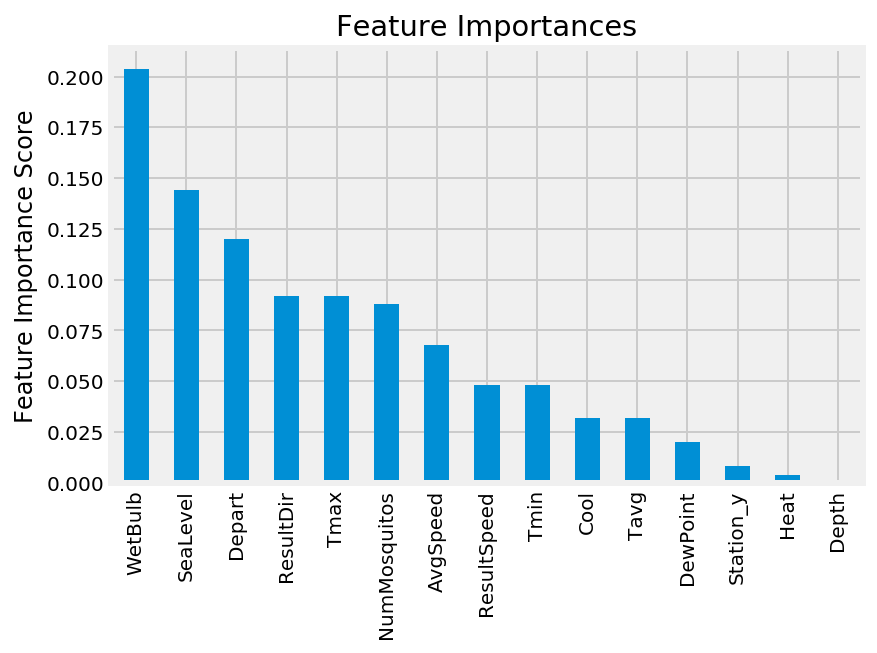

In [161]:
list_2 = zip(list(X.columns), list(grid.best_estimator_.steps[1][1].feature_importances_))
pl = pd.Series(dict(list_2)).sort_values(ascending=False)
pl.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [163]:
#Gradientboosting with PCA
from sklearn.ensemble import GradientBoostingClassifier
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=4)),
    ('clf', GradientBoostingClassifier(random_state=42))])
param_grid = dict(reduce_dims__n_components=[4,6,8],
                  clf__min_samples_split=[50, 100],
                  clf__min_samples_leaf=[1,2,4],
                  clf__max_features=['auto','sqrt', 'log2'],
                  clf__max_depth = [5,6,7,8]
                 )

gb_random = RandomizedSearchCV(pipeline, cv=3, n_jobs=-1, param_distributions=param_grid, n_iter = 100, verbose=2, scoring='roc_auc', random_state=42)
gb_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   57.6s finished
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reduce_dims', PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              lea...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'reduce_dims__n_components': [4, 6, 8], 'clf__min_samples_split': [50, 100], 'clf__min_samples_leaf': [1, 2, 4], 'clf__max_features': ['auto', 'sqrt', 'log2'], 'clf__max_depth': [5, 6, 7, 8]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=2)

In [164]:
gb_random.best_params_

{'reduce_dims__n_components': 8,
 'clf__min_samples_split': 100,
 'clf__min_samples_leaf': 2,
 'clf__max_features': 'log2',
 'clf__max_depth': 6}

In [165]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=8)),
    ('clf', GradientBoostingClassifier(min_samples_leaf=2, max_depth= 6,random_state=42))])

param_grid = dict(clf__min_samples_split=[100,150],
                  clf__max_features=['auto','sqrt', 'log2']
                 )


grid = GridSearchCV(pipeline, cv=3, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
grid.score(X_test, y_test)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__max_features=auto, clf__min_samples_split=100 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
[Parallel(n_jobs=1)]: Done   1 o

[CV]  clf__max_features=auto, clf__min_samples_split=100, total=   0.4s
[CV] clf__max_features=auto, clf__min_samples_split=100 ..............


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV]  clf__max_features=auto, clf__min_samples_split=100, total=   0.4s
[CV] clf__max_features=auto, clf__min_samples_split=100 ..............


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV]  clf__max_features=auto, clf__min_samples_split=100, total=   0.4s
[CV] clf__max_features=auto, clf__min_samples_split=150 ..............


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV]  clf__max_features=auto, clf__min_samples_split=150, total=   0.5s
[CV] clf__max_features=auto, clf__min_samples_split=150 ..............


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV]  clf__max_features=auto, clf__min_samples_split=150, total=   0.5s
[CV] clf__max_features=auto, clf__min_samples_split=150 ..............


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV]  clf__max_features=auto, clf__min_samples_split=150, total=   0.5s
[CV] clf__max_features=sqrt, clf__min_samples_split=100 ..............


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV]  clf__max_features=sqrt, clf__min_samples_split=100, total=   0.3s
[CV] clf__max_features=sqrt, clf__min_samples_split=100 ..............


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV]  clf__max_features=sqrt, clf__min_samples_split=100, total=   0.3s
[CV] clf__max_features=sqrt, clf__min_samples_split=100 ..............


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV]  clf__max_features=sqrt, clf__min_samples_split=100, total=   0.3s
[CV] clf__max_features=sqrt, clf__min_samples_split=150 ..............


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV]  clf__max_features=sqrt, clf__min_samples_split=150, total=   0.3s
[CV] clf__max_features=sqrt, clf__min_samples_split=150 ..............


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV]  clf__max_features=sqrt, clf__min_samples_split=150, total=   0.3s
[CV] clf__max_features=sqrt, clf__min_samples_split=150 ..............


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV]  clf__max_features=sqrt, clf__min_samples_split=150, total=   0.3s
[CV] clf__max_features=log2, clf__min_samples_split=100 ..............


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV]  clf__max_features=log2, clf__min_samples_split=100, total=   0.4s
[CV] clf__max_features=log2, clf__min_samples_split=100 ..............


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV]  clf__max_features=log2, clf__min_samples_split=100, total=   0.5s
[CV] clf__max_features=log2, clf__min_samples_split=100 ..............


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV]  clf__max_features=log2, clf__min_samples_split=100, total=   0.3s
[CV] clf__max_features=log2, clf__min_samples_split=150 ..............


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV]  clf__max_features=log2, clf__min_samples_split=150, total=   0.3s
[CV] clf__max_features=log2, clf__min_samples_split=150 ..............


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV]  clf__max_features=log2, clf__min_samples_split=150, total=   0.3s
[CV] clf__max_features=log2, clf__min_samples_split=150 ..............


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    7.0s finished
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV]  clf__max_features=log2, clf__min_samples_split=150, total=   0.3s
0.8608665033168706
{'mean_fit_time': array([0.42206097, 0.48104231, 0.30102706, 0.30116622, 0.37741605,
       0.29926149]), 'std_fit_time': array([0.01566036, 0.02268977, 0.03008158, 0.02752767, 0.06395483,
       0.02120296]), 'mean_score_time': array([0.00757368, 0.00881457, 0.0085489 , 0.01070142, 0.0082109 ,
       0.00794029]), 'std_score_time': array([0.00065493, 0.00143972, 0.00209058, 0.00027055, 0.00114106,
       0.000796  ]), 'param_clf__max_features': masked_array(data=['auto', 'auto', 'sqrt', 'sqrt', 'log2', 'log2'],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_clf__min_samples_split': masked_array(data=[100, 150, 100, 150, 100, 150],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'clf__max_features': 'auto', 'clf__min_samples_split': 100}, {'clf__max_f

/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.8984085111317255

In [166]:
grid.best_params_

{'clf__max_features': 'log2', 'clf__min_samples_split': 100}

Text(0, 0.5, 'Feature Importance Score')

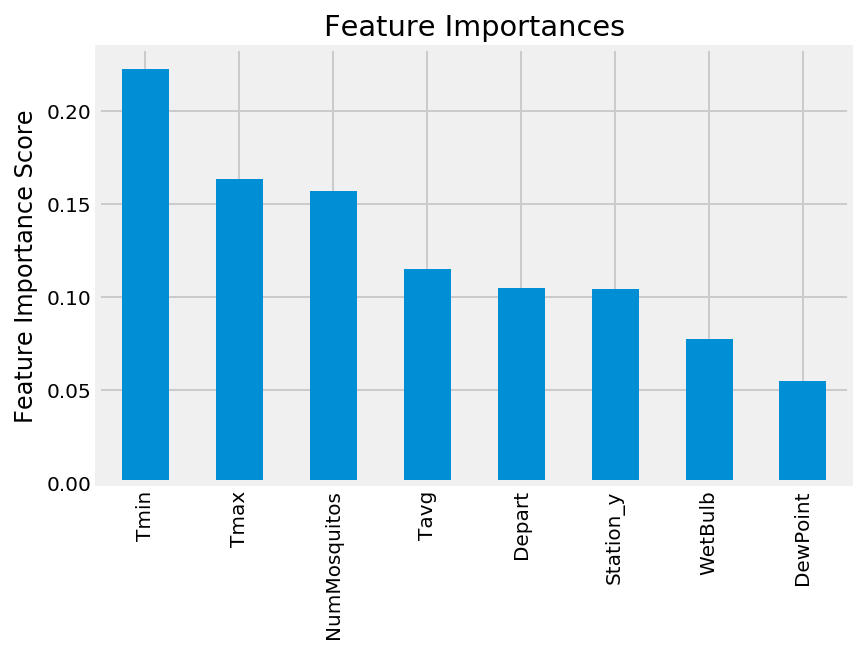

In [167]:
list_2 = zip(list(X.columns), list(grid.best_estimator_.steps[2][1].feature_importances_))
pl = pd.Series(dict(list_2)).sort_values(ascending=False)
pl.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [168]:
#gradientboosting without PCA
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', GradientBoostingClassifier(random_state=42))])
param_grid = dict(clf__min_samples_split=[50, 100],
                  clf__min_samples_leaf=[1,2,4],
                  clf__max_features=['auto','sqrt', 'log2'],
                  clf__max_depth = [5,6,7,8]
                 )

gb_random = RandomizedSearchCV(pipeline, cv=3, n_jobs=-1, param_distributions=param_grid, n_iter = 100, verbose=2, scoring='roc_auc', random_state=42)
gb_random.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   44.8s finished
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).t

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'clf__min_samples_split': [50, 100], 'clf__min_samples_leaf': [1, 2, 4], 'clf__max_features': ['auto', 'sqrt', 'log2'], 'clf__max_depth': [5, 6, 7, 8]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=2)

In [169]:
gb_random.best_params_

{'clf__min_samples_split': 50,
 'clf__min_samples_leaf': 1,
 'clf__max_features': 'sqrt',
 'clf__max_depth': 5}

In [170]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', GradientBoostingClassifier(min_samples_leaf=1, max_features= 'sqrt',random_state=42))])

param_grid = dict(clf__min_samples_split=[30,40,50],
                  clf__max_depth=[3,4,5]
                 )


grid = GridSearchCV(pipeline, cv=3, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
grid.score(X_test, y_test)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] clf__max_depth=3, clf__min_samples_split=30 .....................
[CV] ...... clf__max_depth=3, clf__min_samples_split=30, total=   0.1s
[CV] clf__max_depth=3, clf__min_samples_split=30 .....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
[Parallel(n_jobs=1)]: Done   1 o

[CV] ...... clf__max_depth=3, clf__min_samples_split=30, total=   0.1s
[CV] clf__max_depth=3, clf__min_samples_split=30 .....................
[CV] ...... clf__max_depth=3, clf__min_samples_split=30, total=   0.1s
[CV] clf__max_depth=3, clf__min_samples_split=40 .....................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input

[CV] ...... clf__max_depth=3, clf__min_samples_split=40, total=   0.1s
[CV] clf__max_depth=3, clf__min_samples_split=40 .....................
[CV] ...... clf__max_depth=3, clf__min_samples_split=40, total=   0.1s
[CV] clf__max_depth=3, clf__min_samples_split=40 .....................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input

[CV] ...... clf__max_depth=3, clf__min_samples_split=40, total=   0.1s
[CV] clf__max_depth=3, clf__min_samples_split=50 .....................
[CV] ...... clf__max_depth=3, clf__min_samples_split=50, total=   0.1s
[CV] clf__max_depth=3, clf__min_samples_split=50 .....................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input

[CV] ...... clf__max_depth=3, clf__min_samples_split=50, total=   0.1s
[CV] clf__max_depth=3, clf__min_samples_split=50 .....................
[CV] ...... clf__max_depth=3, clf__min_samples_split=50, total=   0.1s
[CV] clf__max_depth=4, clf__min_samples_split=30 .....................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input

[CV] ...... clf__max_depth=4, clf__min_samples_split=30, total=   0.2s
[CV] clf__max_depth=4, clf__min_samples_split=30 .....................
[CV] ...... clf__max_depth=4, clf__min_samples_split=30, total=   0.2s
[CV] clf__max_depth=4, clf__min_samples_split=30 .....................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input

[CV] ...... clf__max_depth=4, clf__min_samples_split=30, total=   0.2s
[CV] clf__max_depth=4, clf__min_samples_split=40 .....................
[CV] ...... clf__max_depth=4, clf__min_samples_split=40, total=   0.2s
[CV] clf__max_depth=4, clf__min_samples_split=40 .....................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input

[CV] ...... clf__max_depth=4, clf__min_samples_split=40, total=   0.2s
[CV] clf__max_depth=4, clf__min_samples_split=40 .....................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data 

[CV] ...... clf__max_depth=4, clf__min_samples_split=40, total=   0.2s
[CV] clf__max_depth=4, clf__min_samples_split=50 .....................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ...... clf__max_depth=4, clf__min_samples_split=50, total=   0.3s
[CV] clf__max_depth=4, clf__min_samples_split=50 .....................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input

[CV] ...... clf__max_depth=4, clf__min_samples_split=50, total=   0.2s
[CV] clf__max_depth=4, clf__min_samples_split=50 .....................
[CV] ...... clf__max_depth=4, clf__min_samples_split=50, total=   0.2s
[CV] clf__max_depth=5, clf__min_samples_split=30 .....................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ...... clf__max_depth=5, clf__min_samples_split=30, total=   0.3s
[CV] clf__max_depth=5, clf__min_samples_split=30 .....................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ...... clf__max_depth=5, clf__min_samples_split=30, total=   0.3s
[CV] clf__max_depth=5, clf__min_samples_split=30 .....................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ...... clf__max_depth=5, clf__min_samples_split=30, total=   0.2s
[CV] clf__max_depth=5, clf__min_samples_split=40 .....................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ...... clf__max_depth=5, clf__min_samples_split=40, total=   0.2s
[CV] clf__max_depth=5, clf__min_samples_split=40 .....................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ...... clf__max_depth=5, clf__min_samples_split=40, total=   0.4s
[CV] clf__max_depth=5, clf__min_samples_split=40 .....................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ...... clf__max_depth=5, clf__min_samples_split=40, total=   0.2s
[CV] clf__max_depth=5, clf__min_samples_split=50 .....................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ...... clf__max_depth=5, clf__min_samples_split=50, total=   0.3s
[CV] clf__max_depth=5, clf__min_samples_split=50 .....................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ...... clf__max_depth=5, clf__min_samples_split=50, total=   0.3s
[CV] clf__max_depth=5, clf__min_samples_split=50 .....................


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    5.8s finished
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


[CV] ...... clf__max_depth=5, clf__min_samples_split=50, total=   0.3s
0.8902890127118777
{'mean_fit_time': array([0.12925029, 0.13289316, 0.13184158, 0.18382438, 0.19406501,
       0.19910812, 0.24605401, 0.27965466, 0.2740856 ]), 'std_fit_time': array([0.00561165, 0.00741964, 0.00278598, 0.01467695, 0.02802595,
       0.03681109, 0.00951839, 0.07333301, 0.03266002]), 'mean_score_time': array([0.00532269, 0.00533024, 0.00606513, 0.00849994, 0.00726461,
       0.00724856, 0.0069263 , 0.00771205, 0.00719587]), 'std_score_time': array([0.00011447, 0.00024311, 0.00049304, 0.00141354, 0.00032705,
       0.00071511, 0.00063213, 0.00150202, 0.00033821]), 'param_clf__max_depth': masked_array(data=[3, 3, 3, 4, 4, 4, 5, 5, 5],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_clf__min_samples_split': masked_array(data=[30, 40, 50, 30, 40, 50, 30, 40, 50],
             mask=[False, False,

/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.9048440398886828

In [171]:
grid.best_params_

{'clf__max_depth': 3, 'clf__min_samples_split': 30}

Text(0, 0.5, 'Feature Importance Score')

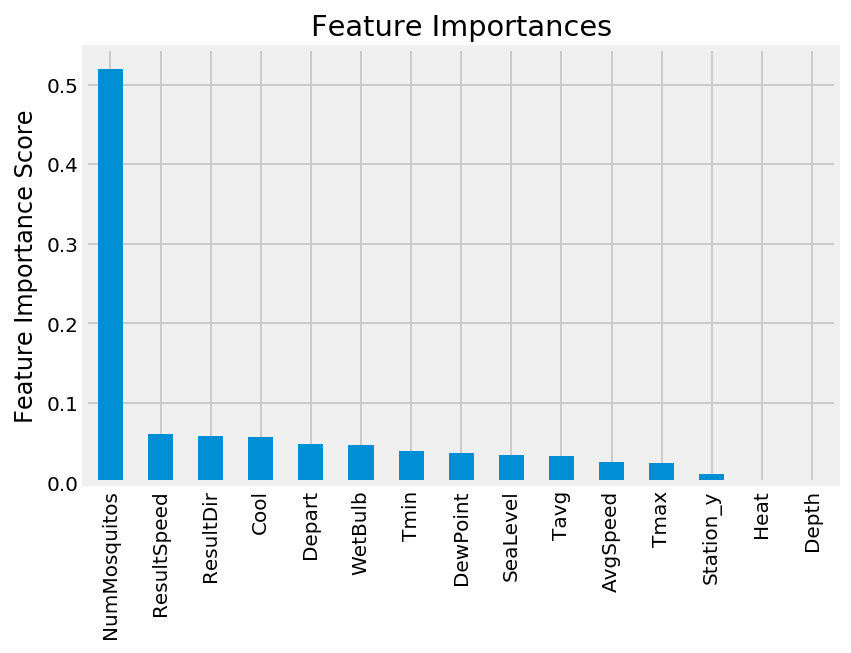

In [172]:
list_2 = zip(list(X.columns), list(grid.best_estimator_.steps[1][1].feature_importances_))
pl = pd.Series(dict(list_2)).sort_values(ascending=False)
pl.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

Some takeaways, random forest seems to do the best. PCA did not really help much and could be due to small number of features. Adaboost learning rate seems to balance off with the estimators. higher estimators = lower learning rate. When doing decision trees, features that are the most important is heavily skewed to number of mosquitos. Baseline should be treated as 94% because this is supposed to be rare. Considering a binary classification problem, one can always assume the mosquito is not infected and still get it right 94% of the time.

Moving forward:
Makes sense to predict the number of mosquitos first? then do a classification? Read other solutions. Find ways to process the features, date/time stuff and encoding of some of the categorical ones. Break the baseline.


Done:
Pipelines
Gridsearch
Randomized search
PCA